# Multilabel classification for amorphous silicon structures

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
from steinhardt import get_steinhardt_params

## Data pre-processing

### Get dataset with atomic coordinates and turn it into a dataset with Stenhard OPs

In [31]:
df=pd.read_pickle('/u/vld/sjoh5417/part-2/week-2/week-2/aSi-classifier/df_npt_anneal_293K_ptm-labels_-1.pckl.gzip', compression='gzip')

### Keep labels to 1 for all crystal-like environments

In [47]:
# Create an array with the labels

label_arrays=[]
num_rows = df.shape[0]
for i in range(0, num_rows):
    labels_structure_i=(df['PTM_cat_labels'][i]) #this is a vector with one label for each atom in the structure
    label_arrays.append(labels_structure_i) #append the label vector for each structure to the label_arrays list

labels=np.hstack((label_arrays)) # stack the vectors 

In [48]:
num_ones = np.sum(labels == 1)
num_twos= np.sum(labels == 2)
num_threes= np.sum(labels == 3)
print({f:num for f,num in zip(['Paracrystalline', 'Polycrystalline', 'Diamond'], [num_ones, num_twos, num_threes])})

{'Paracrystalline': 8485, 'Polycrystalline': 152522, 'Diamond': 13008}


In [ ]:
# Generate steinhardt parameters and stack them in a numpy array

num_rows = df.shape[0]
arrays=[]
stein=np.empty(shape=(0, 30))
for i in range(0, num_rows):
    stein_params_structure_i=get_steinhardt_params(df['ase_atoms'][i], cutoff_radius=10, numb_neighbours=16, q_l_values = np.arange(3,13,1), w_l_values=np.arange(4,14,2))
    arrays.append(stein_params_structure_i)
    
result=np.vstack((arrays))

    Save the result as a CSV file#     # Save the result as a CSV
np.savetxt('steinhardt_params_cutoff_10.csv', result, delimiter=',')


In [49]:
# Get steinhard parameters from csv file
steinhard_params = np.genfromtxt('/u/vld/sjoh5417/part-2/week-2/week-2/aSi-classifier/steinhard_param_storage.csv', delimiter=',')[1:]


### Split the dataset with Steinhardt OPs into a training and test set

In [50]:
(X_train,X_test,Y_train, Y_test)=train_test_split(steinhard_params, labels, test_size=0.2, random_state=42)


## Resampling (optional)

In [16]:
# train_dataframe = pd.DataFrame(np.concatenate([X_train, Y_train.reshape(-1, 1)], axis=1))

In [17]:
# #separate minority and majority classes
# negative = train_dataframe[train_dataframe[30]==0]
# positive = train_dataframe[train_dataframe[30]==1]

In [23]:
# #downsample majority
# from sklearn.utils import resample

# pos_downsampled = resample(positive,
#  replace=True, # sample with replacement
#  n_samples=int(len(positive)/20), # match number in minority class
#  random_state=27) # reproducible results# combine minority and downsampled majority
# downsampled = pd.concat([negative, pos_downsampled])# check new class counts

In [24]:
# X_train_downsampled = downsampled.iloc[:, :-1].values
# Y_train_downsampled = downsampled.iloc[:, -1].values

In [51]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
scaled_x_train = torch.FloatTensor(scaler.transform(X_train))
scaled_x_test = torch.FloatTensor(scaler.transform(X_test))

## Model set-up

In [52]:
X_train = torch.tensor(scaled_x_train, dtype=torch.float32)
X_test = torch.tensor(scaled_x_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)


train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


/tmp/ipykernel_1858156/1203322134.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(scaled_x_train, dtype=torch.float32)
/tmp/ipykernel_1858156/1203322134.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(scaled_x_test, dtype=torch.float32)


In [53]:
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(30, 24)  # input features: 30, hidden: 16
        self.fc2 = nn.Linear(24, 12)   # hidden: 16, output hidden: 8
        self.fc3 = nn.Linear(12, 4)    # hidden: 8, output: 1
        self.relu = nn.ReLU()         # ReLU activation function (can define relu here and use it in forward instead of torch.relu)

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Activation function after first layer
        # Alternative way to apply activation function
        # x=self.fc1(x)
        # x=self.relu(x)
        x = torch.relu(self.fc2(x))   # Activation function after second layer
        x = self.fc3(x)               # Final layer output
        return x        # Sigmoid activation function for binary classification 


In [85]:
model = NNClassifier()
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [86]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        # labels = torch.unsqueeze(labels, 1)  # Add an extra dimension to the labels

        labels=labels.long()
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/50], Loss: 0.0494
Epoch [2/50], Loss: 0.0391
Epoch [3/50], Loss: 0.0368
Epoch [4/50], Loss: 0.0357
Epoch [5/50], Loss: 0.0352
Epoch [6/50], Loss: 0.0349
Epoch [7/50], Loss: 0.0347
Epoch [8/50], Loss: 0.0344
Epoch [9/50], Loss: 0.0342
Epoch [10/50], Loss: 0.0340
Epoch [11/50], Loss: 0.0338
Epoch [12/50], Loss: 0.0336
Epoch [13/50], Loss: 0.0336
Epoch [14/50], Loss: 0.0335
Epoch [15/50], Loss: 0.0333
Epoch [16/50], Loss: 0.0332
Epoch [17/50], Loss: 0.0332
Epoch [18/50], Loss: 0.0330
Epoch [19/50], Loss: 0.0329
Epoch [20/50], Loss: 0.0329
Epoch [21/50], Loss: 0.0329
Epoch [22/50], Loss: 0.0329
Epoch [23/50], Loss: 0.0328
Epoch [24/50], Loss: 0.0328
Epoch [25/50], Loss: 0.0327
Epoch [26/50], Loss: 0.0326
Epoch [27/50], Loss: 0.0326
Epoch [28/50], Loss: 0.0325
Epoch [29/50], Loss: 0.0325
Epoch [30/50], Loss: 0.0324
Epoch [31/50], Loss: 0.0324
Epoch [32/50], Loss: 0.0324
Epoch [33/50], Loss: 0.0324
Epoch [34/50], Loss: 0.0323
Epoch [35/50], Loss: 0.0323
Epoch [36/50], Loss: 0.0323
E

## Testing

In [87]:
import seaborn as sns

# Evaluation mode (disable gradients for testing)
model.eval()

# Initialize counts for confusion matrix
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

# Track correct predictions
correct = 0
total = 0
list_of_ones=0

with torch.no_grad():  # No need to calculate gradients during testing
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        # predicted = predicted.view(-1)  # Flatten predicted (N, 1) -> (N,)
        # labels = labels.view(-1)        # Flatten labels (1, N) -> (N,)
        correct+=(predicted==labels).sum().item()

print(f'Accuracy: {correct/total:.4f}')
    




Accuracy: 0.9883


Old confusion matrix

<Figure size 640x480 with 0 Axes>

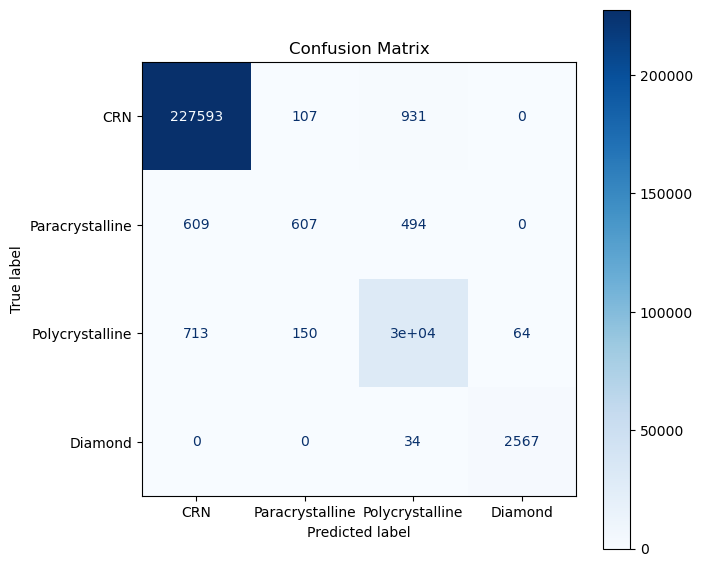

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
    fig, ax = plt.subplots(figsize=(7, 7))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    # disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Plot the confusion matrix
plt.savefig('confusion_matrix_multi_label_class.png')
plot_confusion_matrix(model, test_loader)

### New confusion matrix

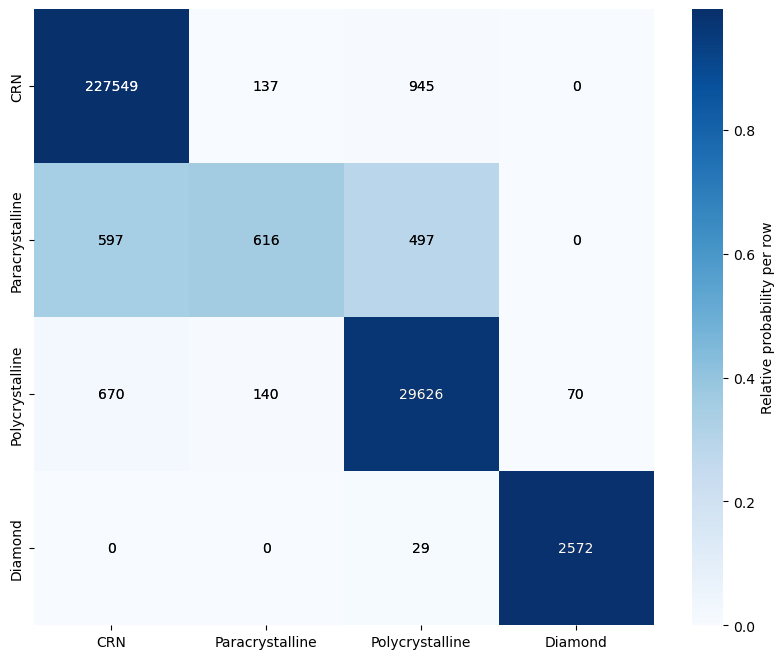

In [88]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    cm = confusion_matrix(y_true, y_pred)

    cm_normalised=cm/cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", cbar=False, xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
    ax=sns.heatmap(cm_normalised, annot=False,  cmap='Blues', cbar=True,
                 cbar_kws={"label":"Relative probability per row"},
                 xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Set text color to white if the background is dark (intensity > 0.5)
            color = "white" if cm_normalised[i, j] > 0.5 else "black"
            ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:.0f}", ha="center", va="center", color=color)
    plt.savefig('confusion_matrix_multi_label_class_3.png')
    plt.show()



plot_confusion_matrix(model, test_loader)
    

In [89]:
from sklearn.metrics import classification_report

def print_classification_report(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        
    print(classification_report(y_true, y_pred))

print_classification_report(model, test_loader)


    

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    228631
         1.0       0.69      0.36      0.47      1710
         2.0       0.95      0.97      0.96     30506
         3.0       0.97      0.99      0.98      2601

    accuracy                           0.99    263448
   macro avg       0.90      0.83      0.85    263448
weighted avg       0.99      0.99      0.99    263448

